In [39]:
import kagglehub
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
# Final Dataset source from: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?select=phishing_email.csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
data=pd.read_csv('/content/drive/MyDrive/ECE 597 Capstone/phishing_email.csv')

In [42]:
data.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [43]:
data['text'] = data['text_combined']
data = data.drop(columns=['text_combined'])
data['text'] = data['text'].str.lower()

# Clean URLs special characters
def clean_text(text):
    text = re.sub(r'\S+@\S+', ' ', text)  # remove email addresses
    text = re.sub(r'http\S+|www\S+', ' ', text)  # remove URLs
    text = re.sub(r'\d+', ' ', text)  # remove numbers
    text = re.sub(r'[^\w\s]', ' ', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    text = re.sub(r'subject', '', text).strip()# remove subject
    return text

data['text'] = data['text'].apply(clean_text)

# Stop words + Lemmatization = Tokenize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['text'] = data['text'].apply(tokenize_and_lemmatize)

In [44]:
data.head()

,label,text
0,0,hpl nom may see attached file hplno xl hplno xl
1,0,nom actual vols th forwarded sabrae zajac hou ...
2,0,enron actuals march april estimated actuals ma...
3,0,hpl nom may see attached file hplno xl hplno xl
4,0,hpl nom june see attached file hplno xl hplno xl


In [45]:
# Using 10% of the data as a final test set and applying k-fold validation on the remaining 90%

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# Split data into 90% for cross-validation and 10% for final test set
X = data['text']
y = data['label']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Apply k-fold validation on the remaining 90%
n_splits = 5  # You can adjust the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Print the sizes of the splits for demonstration
print("K-Fold Split Sizes:")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    print(f"Fold {fold+1}:")
    print(f"  Training set size: {len(X_train)}")
    print(f"  Validation set size: {len(X_val)}")

# The final test set (X_test, y_test) is held out until the end for final evaluation
print("\nFinal test set size:")
print(f"  Test set size: {len(X_test)}")

K-Fold Split Sizes:
Fold 1:
  Training set size: 59389
  Validation set size: 14848
Fold 2:
  Training set size: 59389
  Validation set size: 14848
Fold 3:
  Training set size: 59390
  Validation set size: 14847
Fold 4:
  Training set size: 59390
  Validation set size: 14847
Fold 5:
  Training set size: 59390
  Validation set size: 14847

Final test set size:
  Test set size: 8249


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize TF-IDF Vectorizer
# You can adjust parameters like max_features, min_df, max_df, ngram_range
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# Fit the vectorizer on the full training data (X_train_full)
X_train_full_tfidf = tfidf_vectorizer.fit_transform(X_train_full)

print("\nTraining and evaluating Logistic Regression model with K-Fold Cross-Validation:")
# Now, within the k-fold loop, transform the train and validation sets for each fold and train the model
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full)):
    print(f"Fold {fold+1}:")

    # Get the training and validation data for this fold
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    # Transform the training and validation sets using the fitted vectorizer
    X_train_tfidf = tfidf_vectorizer.transform(X_train)
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

    # Initialize and train the Logistic Regression model
    logistic_model = LogisticRegression(random_state=42)
    logistic_model.fit(X_train_tfidf, y_train)

    # Evaluate the model on the validation set
    y_val_pred = logistic_model.predict(X_val_tfidf)
    accuracy = accuracy_score(y_val, y_val_pred)

    print(f"  Validation Accuracy: {accuracy:.4f}")

# After the loop, train the final model on the full X_train_full
# and evaluate it on the held-out X_test.
print("\nEvaluating final model on the test set:")
# Transform the test set as well
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train the final model on the full training data
final_logistic_model = LogisticRegression(random_state=42)
final_logistic_model.fit(X_train_full_tfidf, y_train_full)

# Evaluate the final model on the test set
y_test_pred = final_logistic_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"  Final model accuracy on the test set: {test_accuracy:.4f}")


Training and evaluating Logistic Regression model with K-Fold Cross-Validation:
Fold 1:
  Validation Accuracy: 0.9802
Fold 2:
  Validation Accuracy: 0.9790
Fold 3:
  Validation Accuracy: 0.9811
Fold 4:
  Validation Accuracy: 0.9828
Fold 5:
  Validation Accuracy: 0.9794

Evaluating final model on the test set:
  Final model accuracy on the test set: 0.9835


Precision on the test set: 0.9808
Recall on the test set: 0.9876


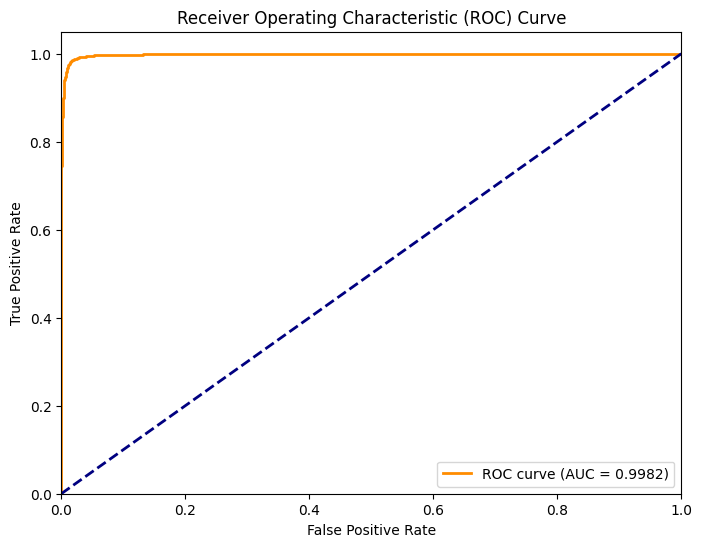

In [47]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate Precision and Recall on the test set
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"Precision on the test set: {precision:.4f}")
print(f"Recall on the test set: {recall:.4f}")

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, final_logistic_model.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import confusion_matrix

# y_true: true labels
# y_pred: predicted labels from your model
cm = confusion_matrix(y_test, y_test_pred)

print(cm)


[[3877   83]
 [  53 4236]]


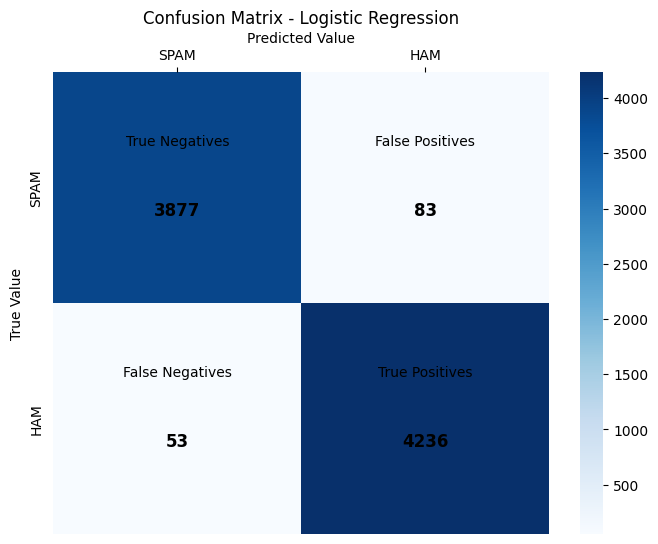

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn heatmap
fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=['SPAM', 'HAM'], yticklabels=['SPAM', 'HAM'], ax=ax) # Pass ax to heatmap

# Add custom annotations
labels = np.array([['True Negatives', 'False Positives'],
                   ['False Negatives', 'True Positives']])

# Get the center positions for the annotations
# The positions are slightly adjusted to be above the numbers
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.3, labels[i, j],
                 ha="center", va="center", color="black", fontsize=10)
        plt.text(j + 0.5, i + 0.6, cm[i, j],
                 ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.xlabel('Predicted Value')
plt.ylabel('True Value') # Keep ylabel for clarity below the matrix
plt.title('Confusion Matrix - Logistic Regression') # Update title

# Move yticklabels to the right and position xlabel at the top
ax.tick_params(left=False, labelleft=True, right=False, labelright=False,
               top=True, labeltop=True, bottom=False, labelbottom=False)

ax.xaxis.set_label_position('top') # Move xlabel to the top
ax.yaxis.set_label_position('left') # Ensure ylabel remains on the left (default)

plt.show()